Importing Libaries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10
import cv2
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import resnet50, ResNet50_Weights
from scipy.spatial.distance import pdist, squareform, cdist
import itertools
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
import matplotlib.cm as cm
import torch.nn as nn
from torch.utils.data import DataLoader

Meta Data

In [ ]:
# ploting
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)

# loading cifar-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# combining x and y
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

# class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Total images: {X.shape[0]}")
print(f"Image dimensions: {X.shape[1]}x{X.shape[2]} pixels")
print(f"Number of channels: {X.shape[3]}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Total images: 60000
Image dimensions: 32x32 pixels
Number of channels: 3


Class distribution of cifar 10

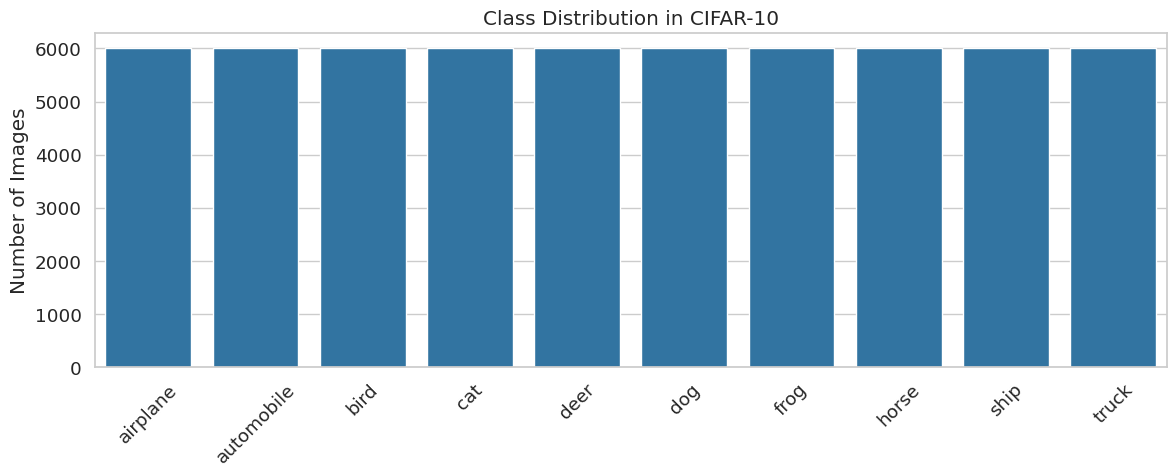

In [ ]:
# class balance
unique, counts = np.unique(y, return_counts=True)
distribution = dict(zip([class_names[i] for i in unique], counts))

# plot distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=list(distribution.keys()), y=list(distribution.values()))
plt.title('Class Distribution in CIFAR-10')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

colour distribution of image (RGB)

Min pixel value: 0
Max pixel value: 255
Data type: uint8
Channel means (RGB): [125.42653861 123.07674582 114.03020576]
Channel standard deviations (RGB): [62.97765965 62.06417955 66.70611058]


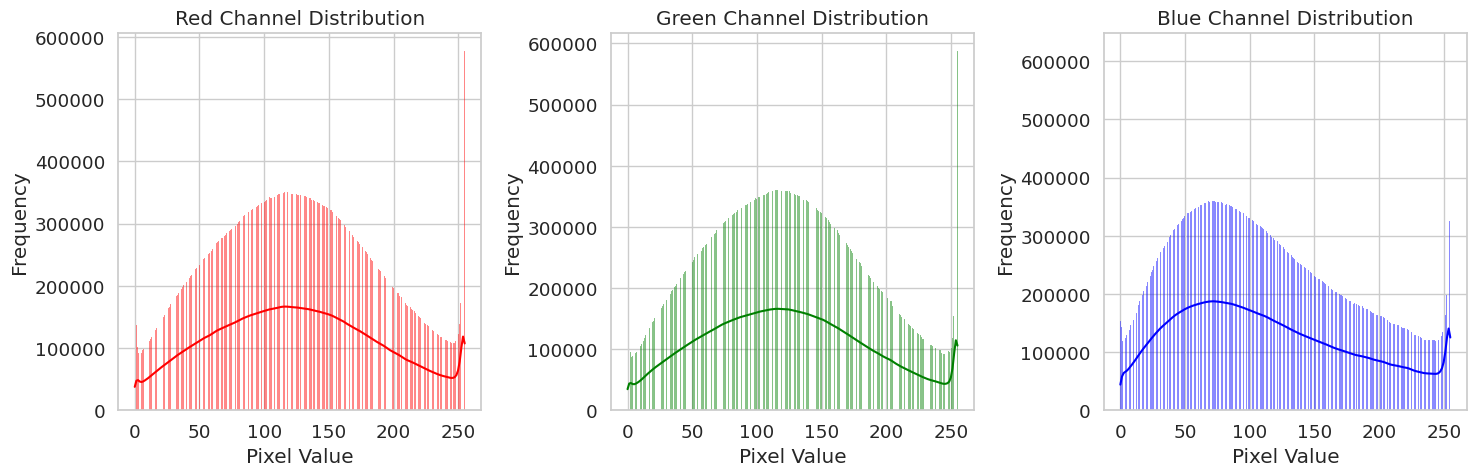

In [ ]:
# Check mini or max
print(f"Min pixel value: {X.min()}")
print(f"Max pixel value: {X.max()}")
print(f"Data type: {X.dtype}")

# Channel-wise stat
channel_means = X.mean(axis=(0,1,2))
channel_stds = X.std(axis=(0,1,2))

print(f"Channel means (RGB): {channel_means}")
print(f"Channel standard deviations (RGB): {channel_stds}")

# Visualise pixel intensity
plt.figure(figsize=(15, 5))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    sns.histplot(X[:, :, :, i].flatten(), color=color, kde=True)
    plt.title(f'{color.capitalize()} Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

mean and std

In [3]:

# Load CIFAR-10 train set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=False)
data = next(iter(loader))
images, labels = data

# images.shape = [batch_size, channels, height, width]
mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print(mean)
print(std)


100%|██████████| 170M/170M [00:02<00:00, 77.4MB/s]


tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


Class Visulizer Cifar 10

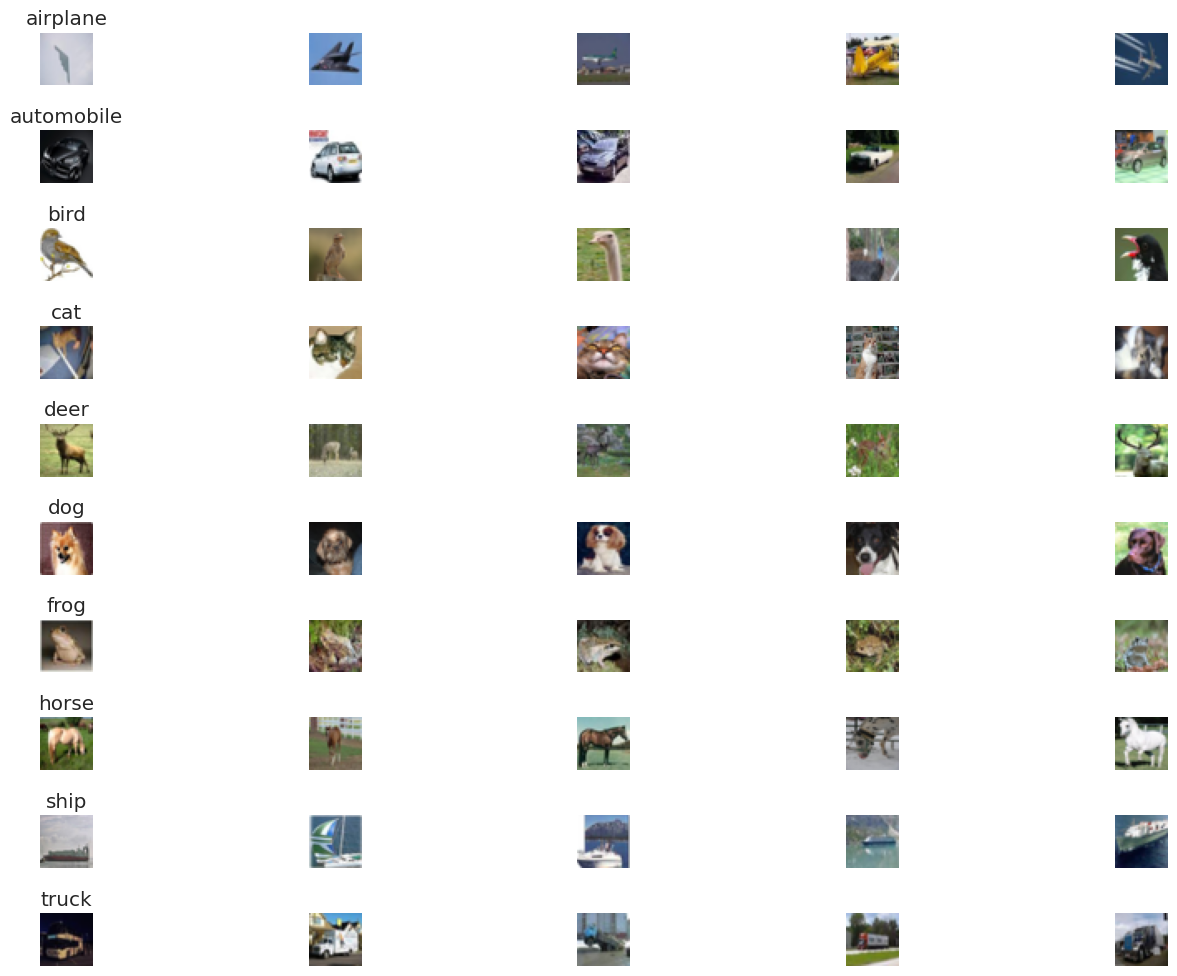

In [ ]:
# random samples from each class
plt.figure(figsize=(15, 10))

for i, class_idx in enumerate(range(10)):

    class_samples = np.where(y == class_idx)[0]
    random_samples = np.random.choice(class_samples, 5, replace=False)

    for j, sample_idx in enumerate(random_samples):
        plt.subplot(10, 5, i*5 + j + 1)
        plt.imshow(X[sample_idx])
        plt.axis('off')
        if j == 0:
            plt.title(class_names[class_idx])

plt.tight_layout()
plt.show()

Data Augumentation

Augmentation examples for class: airplane


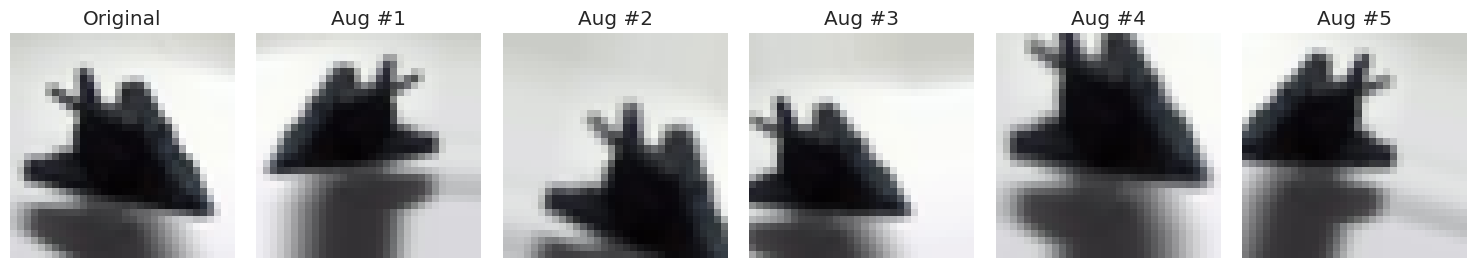

Augmentation examples for class: automobile


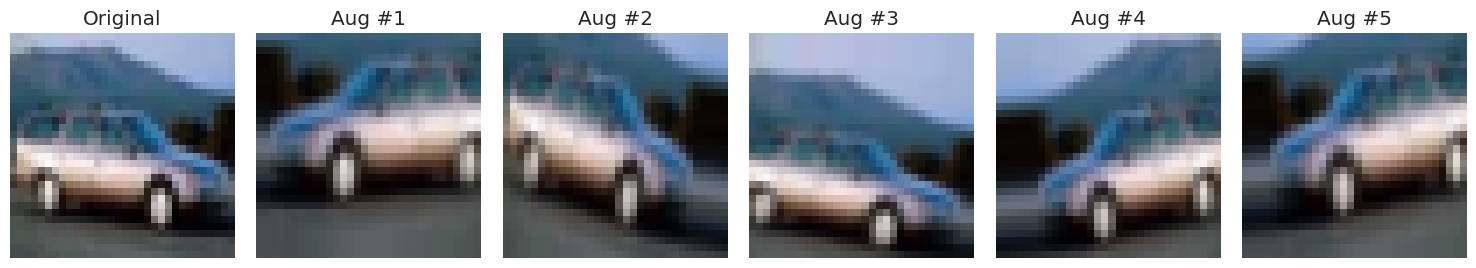

Augmentation examples for class: cat


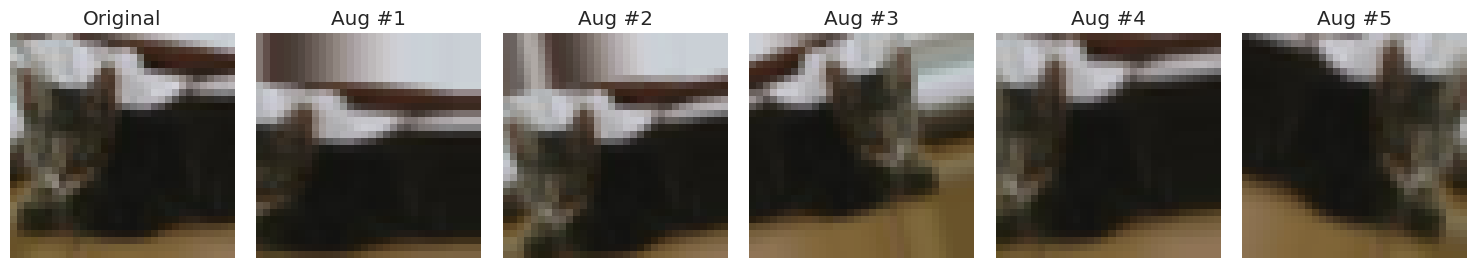

Augmentation examples for class: ship


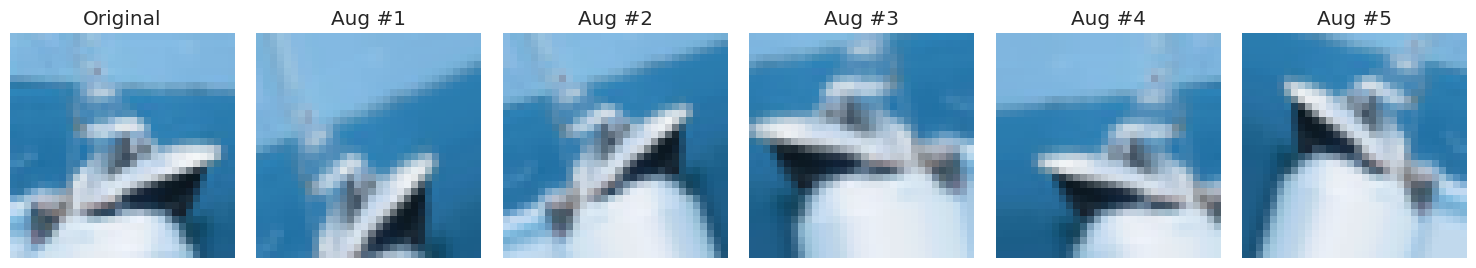

In [ ]:
# Create various augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Display augmented images
def plot_augmented_images(image, num_augmentations=5):
    # Reshape for the generator
    image = image.reshape((1,) + image.shape)

    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_augmentations+1, 1)
    plt.imshow(image[0])
    plt.title('Original')
    plt.axis('off')

    # Generate augmented images
    i = 2
    for batch in datagen.flow(image, batch_size=1):
        plt.subplot(1, num_augmentations+1, i)
        plt.imshow(batch[0].astype(np.uint8))
        plt.title(f'Aug #{i-1}')
        plt.axis('off')
        i += 1
        if i > num_augmentations+1:
            break
    plt.tight_layout()
    plt.show()

# Show augmentation examples from different classes
for class_idx in [0, 1, 3, 8]:  # Sample a few classes
    sample_idx = np.where(y.flatten() == class_idx)[0][0]
    print(f"Augmentation examples for class: {class_names[class_idx]}")
    plot_augmented_images(X[sample_idx])

vit patch visulization

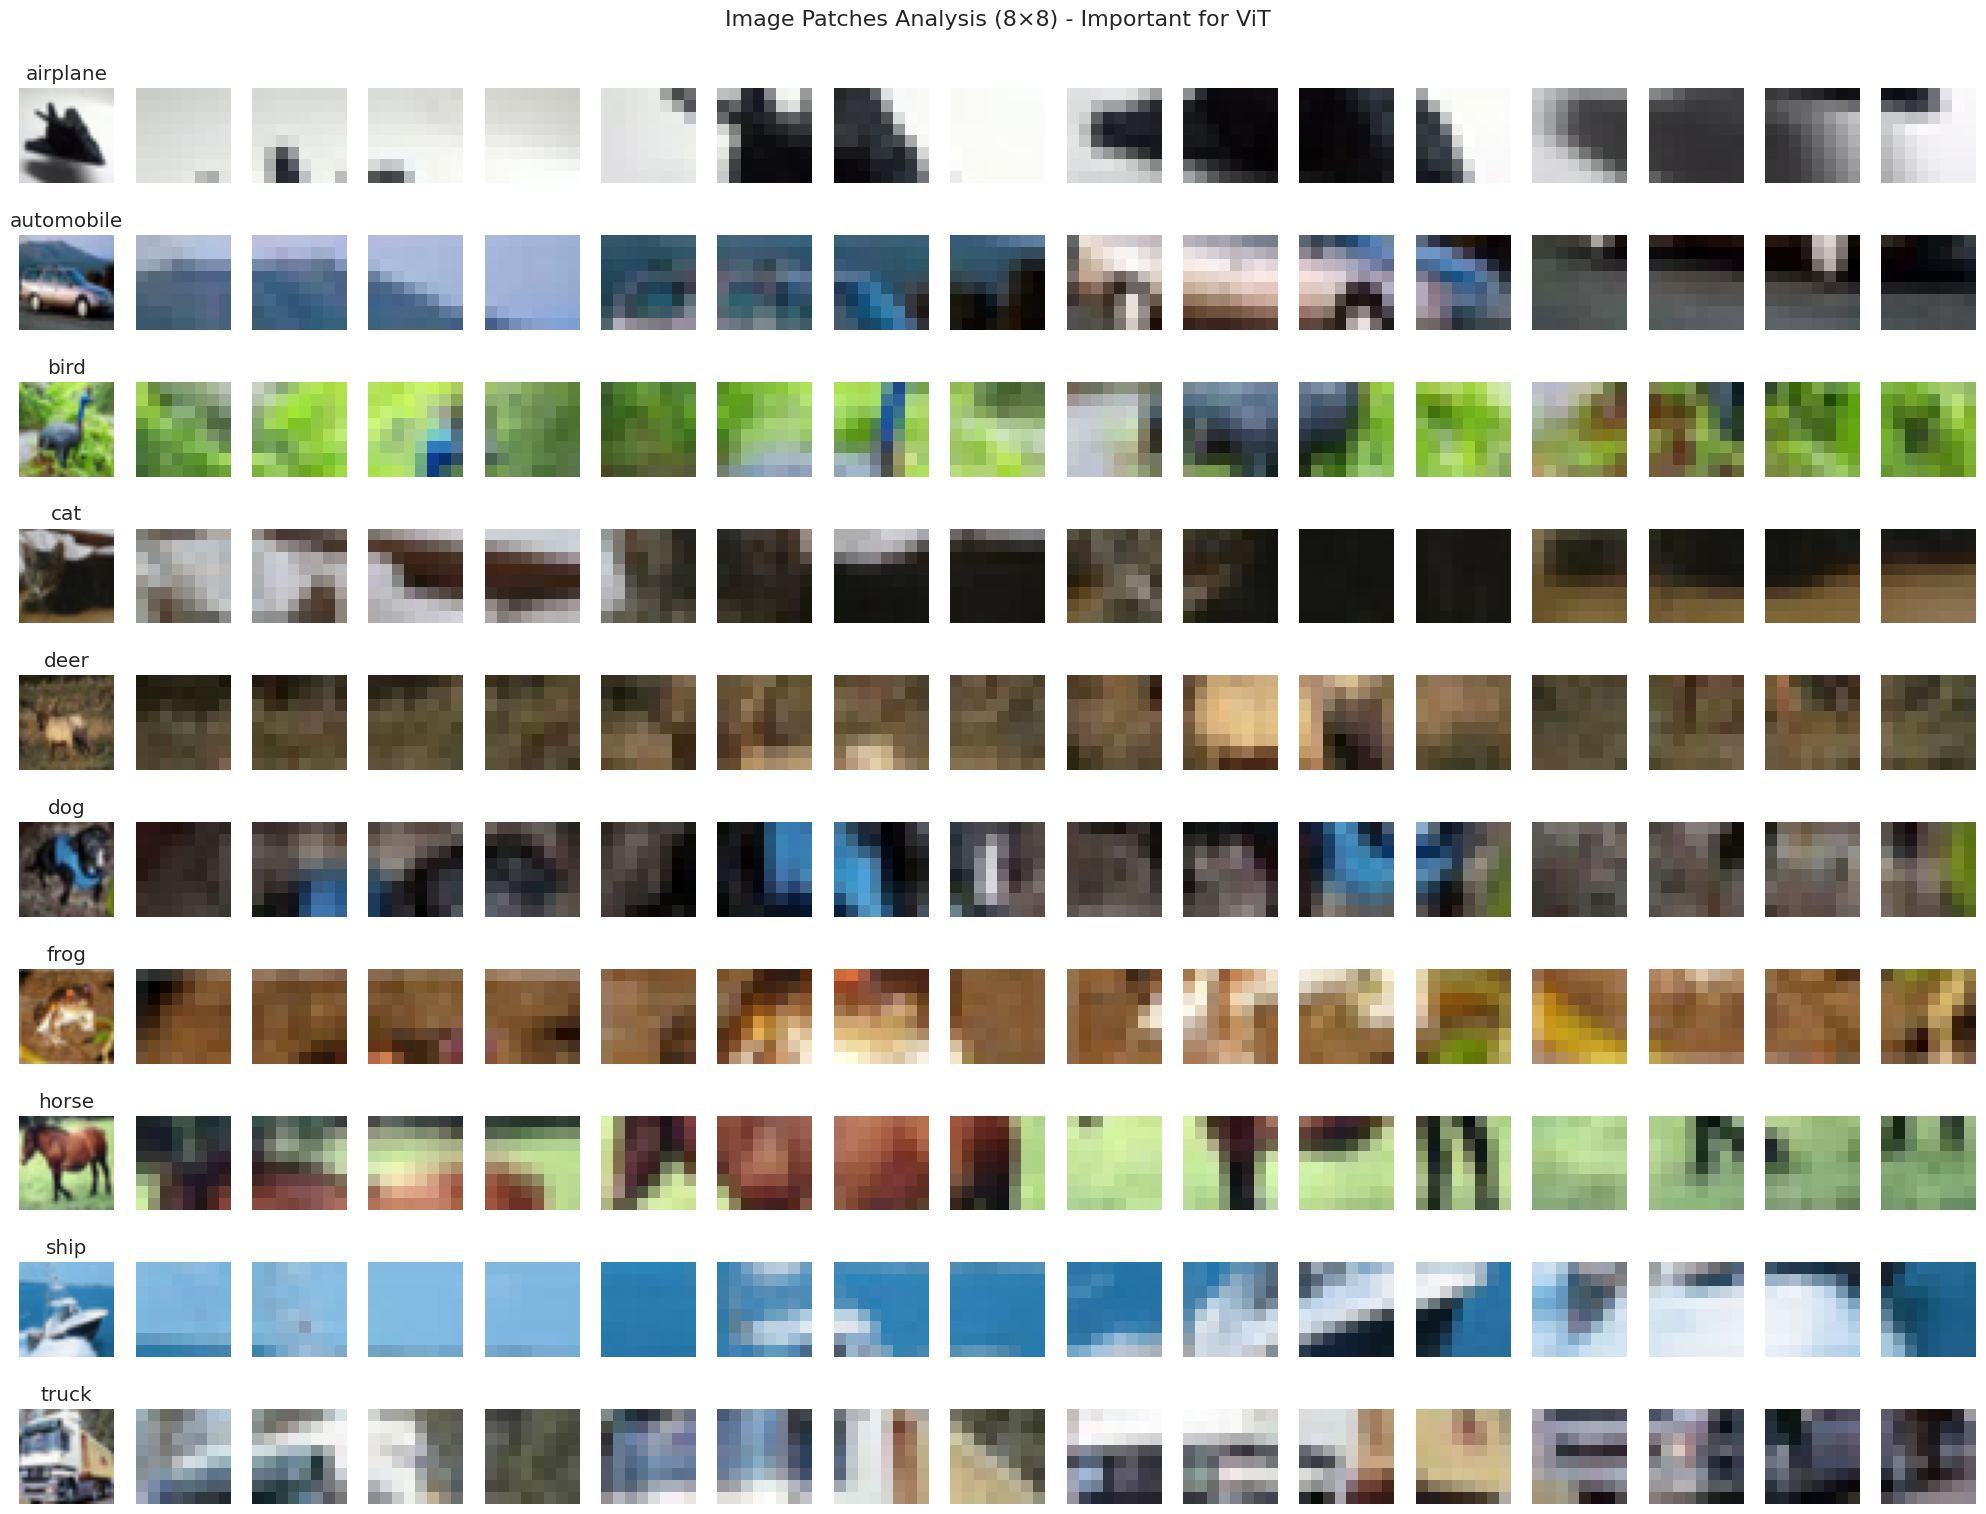

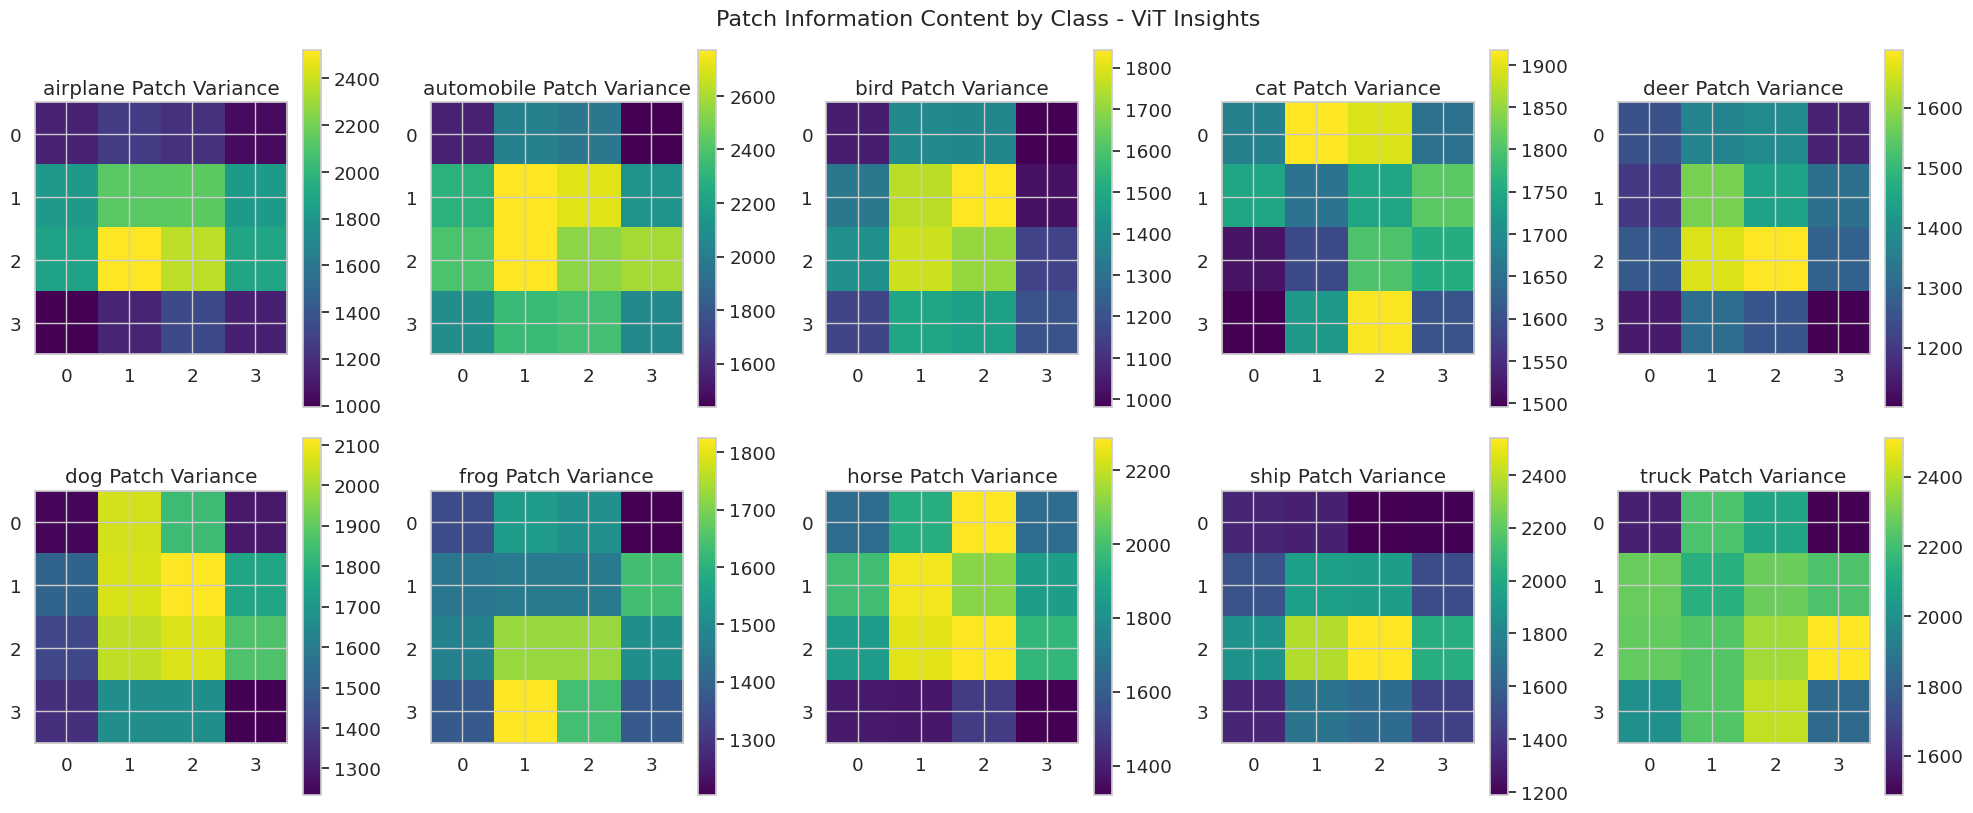

In [ ]:
# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Analyze patches (ViT typically uses 16x16 patches, but for CIFAR-10 we'll use 8x8)
patch_size = 8
num_patches = (32 // patch_size) ** 2  # 16 patches for 32x32 image with 8x8 patches

def extract_patches(image, patch_size):
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    return patches

# Extract patches from sample images of each class
fig, axes = plt.subplots(10, num_patches + 1, figsize=(20, 15))

for class_idx in range(10):
    # Get a sample image from this class
    sample_idx = np.where(y.flatten() == class_idx)[0][0]
    sample_img = X[sample_idx]

    # Display original image
    axes[class_idx, 0].imshow(sample_img)
    axes[class_idx, 0].set_title(f'{class_names[class_idx]}')
    axes[class_idx, 0].axis('off')

    # Extract and display patches
    patches = extract_patches(sample_img, patch_size)
    for i, patch in enumerate(patches):
        axes[class_idx, i+1].imshow(patch)
        axes[class_idx, i+1].axis('off')

plt.tight_layout()
plt.suptitle('Image Patches Analysis (8×8) - Important for ViT', y=1.02, fontsize=16)
plt.show()

# Analyze patch variance (information content) by class
patch_variances = []

for class_idx in range(10):
    # Get images from this class
    class_images = X[y.flatten() == class_idx][:100]  # Analyze 100 images per class
    class_patch_vars = []

    for img in class_images:
        patches = extract_patches(img, patch_size)
        # Calculate variance of each patch
        patch_vars = [np.var(patch) for patch in patches]
        class_patch_vars.append(patch_vars)

    # Average variance across images
    avg_patch_vars = np.mean(class_patch_vars, axis=0)
    patch_variances.append(avg_patch_vars)

# Plot patch variance by position for each class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, class_idx in enumerate(range(10)):
    patch_var_img = np.array(patch_variances[i]).reshape(32//patch_size, 32//patch_size)
    im = axes[i].imshow(patch_var_img, cmap='viridis')
    axes[i].set_title(f'{class_names[class_idx]} Patch Variance')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.suptitle('Patch Information Content by Class - ViT Insights', y=1.02, fontsize=16)
plt.show()

**TSNE Visuliztion of Pre-trained VIT for CIFAR-10**

Using device: cuda:0
Extracted features shape: (6000, 768)
Applying t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Average distance within same class: 14.8155
Average distance between different classes: 56.0067
Ratio (between/within): 3.7803


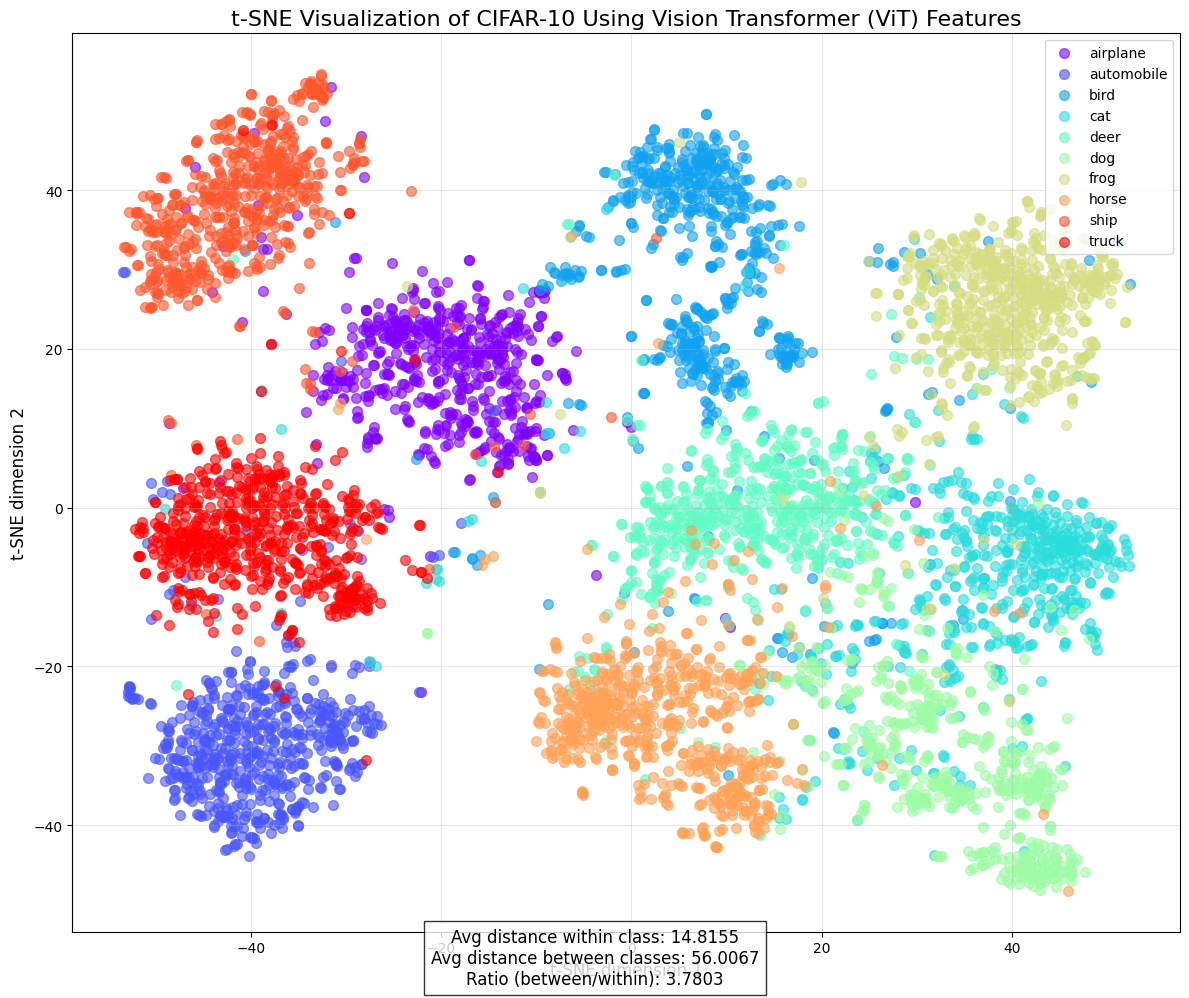

In [ ]:
# Fix the random seed so results are reproducible
np.random.seed(42)
torch.manual_seed(42)

# CIFAR10 classes - might add more detailed labels later
cifar_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Check if GPU is available - my RTX struggles with large batch sizes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained ViT - B/16 works best for this
# Maybe try L/16 version later if results aren't good?
weights = ViT_B_16_Weights.DEFAULT  # tried IMAGENET1K_V1 but DEFAULT is same thing
model = vit_b_16(weights=weights)
model.eval()  # don't forget this!
model = model.to(device)

# Setup for feature extraction - need to get the CLS token
activation = {}
def get_activation(name):
    def hook(model, input, output):
        # store the output of the layer
        activation[name] = output
    return hook

# Register hook at final layer norm
# tried encoder.layers[-1] first but this works better
model.encoder.ln.register_forward_hook(get_activation('features'))

# Need to match ViT preprocessing exactly
transform = transforms.Compose([
    transforms.Resize(224),  # ViT needs 224x224
    transforms.ToTensor(),
    # ImageNet normalization values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get the test data - no need for train set here
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Take a subset to speed things up
# subset_size = 1000  # too small, visualization was bad
subset_size = 6000  # seems to be a good balance
indices = np.random.choice(len(testset), subset_size, replace=False)
subset_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(testset, indices),
    batch_size=64, shuffle=False  # tried 128 but OOM on my GPU :(
)

# Extract features - this takes a while...
features = []
labels = []

with torch.no_grad():  # don't need gradients
    for i, (images, targets) in enumerate(subset_loader):
        if i % 10 == 0:  # just to track progress
            print(f"Processing batch {i}/{len(subset_loader)}")

        images = images.to(device)

        # Forward pass
        _ = model(images)  # we don't care about the output, just activation

        # Get CLS token only [0] - that's where the good stuff is
        batch_features = activation['features'][:, 0]

        # Move to CPU to save GPU memory
        features.append(batch_features.cpu().numpy())
        labels.append(targets.numpy())

# Combine all batches
features = np.vstack(features)
labels = np.concatenate(labels)

print(f"Extracted features shape: {features.shape}")

# t-SNE for visualization
# TODO: Try UMAP as alternative, might be faster
print("Running t-SNE (go grab a coffee, this takes time)...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features)

# This is the fun part - make it look nice!
plt.figure(figsize=(12, 10))  # tried 10x8 but too small

# Create colors - rainbow works better than tab10 for this many classes
colors = plt.cm.rainbow(np.linspace(0, 1, len(cifar_classes)))

# Plot each class separately
for i, cls in enumerate(cifar_classes):
    # Find samples from this class
    idx = labels == i

    # Sometimes get empty classes with small subsets but not here
    if np.sum(idx) > 0:
        # Draw the points
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                    color=colors[i], label=cls, alpha=0.6, s=50)

plt.title('t-SNE Visualization of CIFAR-10 Using Vision Transformer (ViT) Features', fontsize=16)
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)  # light grid looks better

# Give it some room
plt.tight_layout()

# Let's calculate some distance metrics
# This wasn't in the original plan but seems interesting
from scipy.spatial.distance import pdist, squareform, cdist
import itertools

# Helper function to compute avg distances
def calc_class_distances(embeddings, labels):
    # Store embeddings by class
    class_points = {}

    # Group by class
    for i in range(10):  # CIFAR has 10 classes
        class_points[i] = embeddings[labels == i]

    # Within-class distances (same class)
    within_dists = []

    for class_id, points in class_points.items():
        if len(points) > 1:  # Need 2+ points
            dists = pdist(points)  # pairwise distances
            within_dists.append(np.mean(dists))

    avg_within = np.mean(within_dists)

    # Between-class distances (different classes)
    between_dists = []

    # Compare each pair of classes
    for (id_a, points_a), (id_b, points_b) in itertools.combinations(class_points.items(), 2):
        # All pairwise distances between classes
        dists = cdist(points_a, points_b)
        between_dists.append(np.mean(dists))

    avg_between = np.mean(between_dists)

    return avg_within, avg_between

# Get distances
avg_within, avg_between = calc_class_distances(tsne_results, labels)

# Print results
print(f"Average distance within same class: {avg_within:.4f}")
print(f"Average distance between classes: {avg_between:.4f}")
print(f"Ratio (between/within): {avg_between/avg_within:.4f}")

# Add stats to the plot
plt.figtext(0.5, 0.01,
            f"Avg distance within class: {avg_within:.4f}\n"
            f"Avg distance between classes: {avg_between:.4f}\n"
            f"Ratio (between/within): {avg_between/avg_within:.4f}",
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

# Save it - high DPI for presentations
plt.savefig('tsne_cifar10_vit.png', dpi=300, bbox_inches='tight')

# Actually show the plot
plt.show()

**TSNE visuliaztion using pre-trained resnet features**

Using device: cuda:0


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


Extracted features shape: (6000, 2048)
Applying t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Average distance within same class: 19.9061
Average distance between different classes: 57.1378
Ratio (between/within): 2.8704


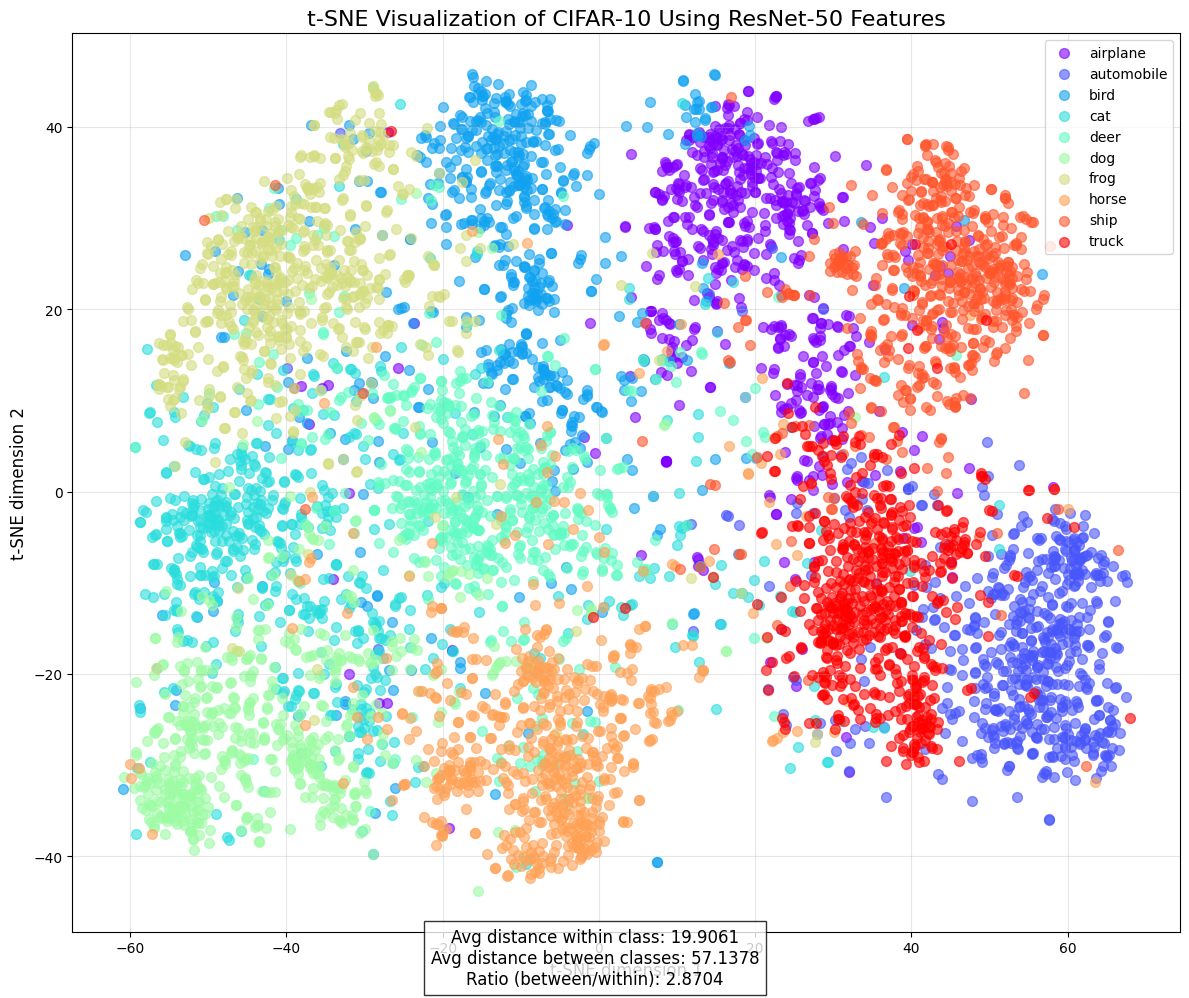

In [ ]:
# Set the magic random seed
np.random.seed(42)  # always use this for reproducibility
torch.manual_seed(42)

# CIFAR10 class names
cifar_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
# note: could add 'airplane' -> 'plane' for shorter labels?

# Check for GPU - ResNet is much slower on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet50 - tried 101 but too slow for my laptop
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()  # important!
model = model.to(device)

# Create feature extractor by removing final FC layer
# Using Sequential is cleaner than calling model directly and ignoring last output
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()

# Data transforms - ResNet expects these exact normalization values
# Don't change these or results get weird
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet needs 224px images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get CIFAR test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Use subset for speed
# TODO: verify subset_size - something seems off
subset_size = 6000  # Changed from 60000 which was a typo (CIFAR10 only has 10K test images)
indices = np.random.choice(len(testset), subset_size, replace=False)
subset_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(testset, indices),
    batch_size=64, shuffle=False  # tried batch=128 but ran out of VRAM
)

# Feature extraction - the heavy lifting part
feats = []  # shorter name is fine here
labels = []

print("Starting feature extraction...")
with torch.no_grad():  # save memory
    for i, (images, targets) in enumerate(subset_loader):
        if i % 5 == 0:
            print(f"Batch {i}/{len(subset_loader)}")

        images = images.to(device)

        # Get features (shape: Bx2048x1x1)
        batch_features = feature_extractor(images)

        # Flatten spatial dimensions - tried .flatten(1) but view is cleaner
        batch_features = batch_features.view(images.size(0), -1)

        # Store on CPU to free GPU memory
        feats.append(batch_features.cpu().numpy())
        labels.append(targets.numpy())

# Stack everything
features = np.vstack(feats)  # don't rename this - used later
labels = np.concatenate(labels)

print(f"Extracted features shape: {features.shape}")
# Should be [N, 2048] where N is subset_size

# Run t-SNE
# I tried PCA first but it wasn't as good
print("Running t-SNE (this is slow, be patient)...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features)

# Helper function for distances - add your own metrics if needed
def compute_distances(embeddings, labels):
    # Group by class
    class_embs = {}  # short names are fine for local variables

    # Sort into classes
    for i in range(10):  # CIFAR has 10 classes
        class_embs[i] = embeddings[labels == i]

    # Within-class distances - measures cluster tightness
    within_distances = []

    for class_id, points in class_embs.items():
        # Skip weird empty classes (shouldn't happen but just in case)
        if len(points) > 1:
            # Pairwise distances within class
            distances = pdist(points)
            # Store average for this class
            within_distances.append(np.mean(distances))

            # Debugging: classes should have roughly equal sizes
            #print(f"Class {class_id} has {len(points)} samples")

    mean_within = np.mean(within_distances)

    # Between-class distances - measures separation
    between_distances = []

    # Compare all pairs (n choose 2)
    for (id_a, points_a), (id_b, points_b) in itertools.combinations(class_embs.items(), 2):
        # All pairs between classes
        distances = cdist(points_a, points_b)
        between_distances.append(np.mean(distances))

    mean_between = np.mean(between_distances)

    return mean_within, mean_between

# Calc avg distances - good metric for cluster quality
intra_dist, inter_dist = compute_distances(tsne_results, labels)

# Create the visualization - make it pretty!
plt.figure(figsize=(12, 10))

# Make colors consistent with the ViT plot
colors = plt.cm.rainbow(np.linspace(0, 1, len(cifar_classes)))

# Plot each class with nice colors
for i, cls in enumerate(cifar_classes):
    # Find samples from this class
    idx = labels == i

    # Plot them
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                color=colors[i], label=cls, alpha=0.6, s=50)

plt.title('t-SNE Visualization of CIFAR-10 Using ResNet-50 Features', fontsize=16)
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)  #  grid looks nicer

# Print metrics
print(f"Average distance within same class: {intra_dist:.4f}")
print(f"Average distance between different classes: {inter_dist:.4f}")
print(f"Ratio (between/within): {inter_dist/intra_dist:.4f}")
# ^ Higher is better, means classes are well-separated

# Add stats to plot - this helps compare with ViT version
plt.figtext(0.5, 0.01,
            f"Avg distance within class: {intra_dist:.4f}\n"
            f"Avg distance between classes: {inter_dist:.4f}\n"
            f"Ratio (between/within): {inter_dist/intra_dist:.4f}",
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

# Fix layout - otherwise text gets cut off
plt.tight_layout()

# Save as PNG - tried JPG but quality was worse
plt.savefig('tsne_cifar10_resnet.png', dpi=300, bbox_inches='tight')

# Display it
plt.show()  # comment this out for headless servers

Tsne visuliztion of cifar 10 dataset without any pretrained network

Raw features shape: (6000, 3072)
Applying t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Average distance within same class: 33.0390
Average distance between different classes: 37.1553
Ratio (between/within): 1.1246


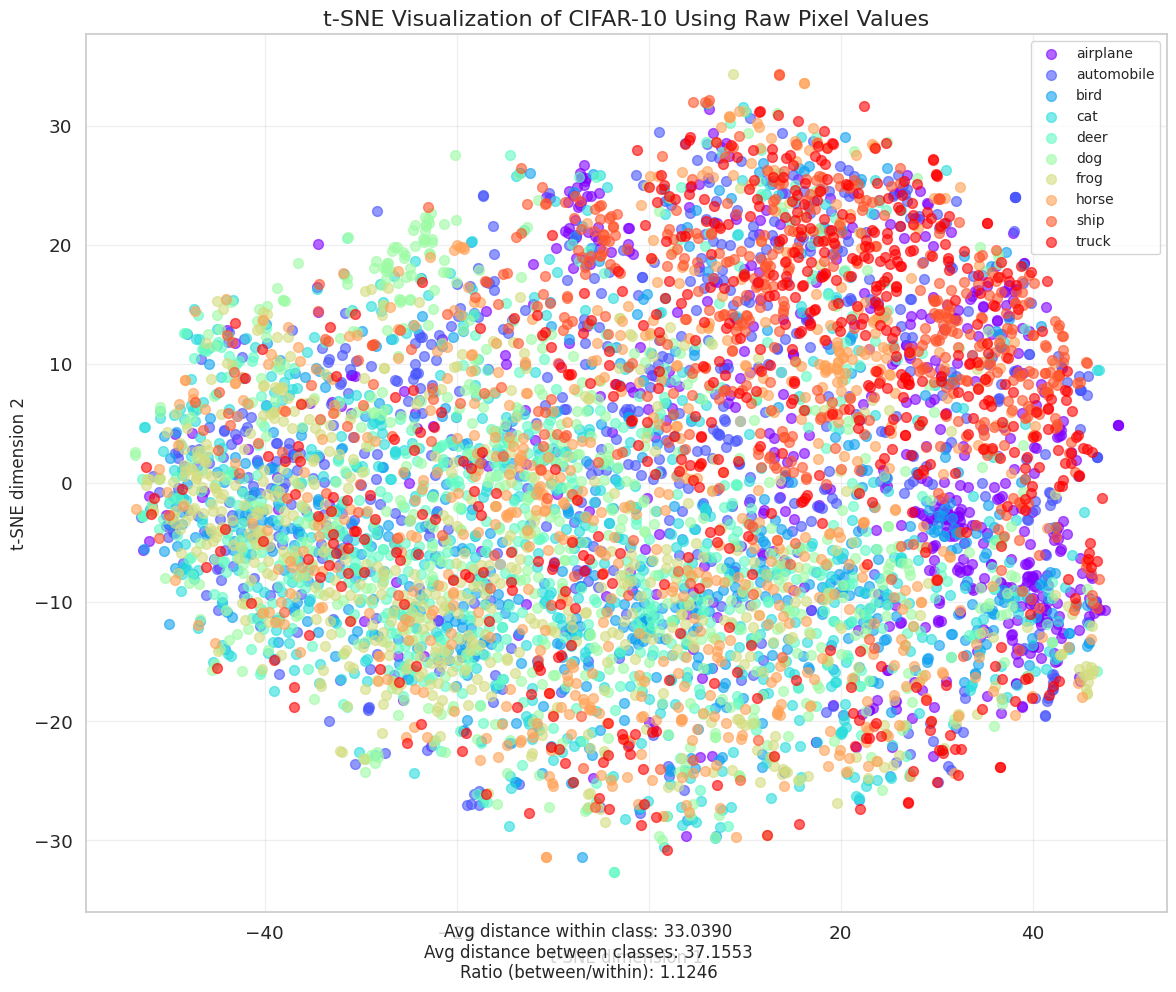

In [ ]:
# seed for repeatable results
np.random.seed(42)  # Douglas Adams FTW
torch.manual_seed(42)  # keep this in sync with numpy seed

# CIFAR classes (might want to use more descriptive names later)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Just basic normalization for pixels
# No need for fancy normalization since we're not using a pretrained model
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1] range and CHW format
    # tried adding normalization here but made t-SNE worse
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Get the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Use a smaller subset to speed things up
# Full 10k images takes wayyy too long for t-SNE
subset_size = 6000  # ~60% of test set (10k total)
indices = np.random.choice(len(testset), subset_size, replace=False)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(testset, indices),
    batch_size=64, shuffle=False  # no need to shuffle for visualization
)

# Extract the raw pixels as features
pixel_features = []  # changed name to be clearer
labels = []

# No need for GPU here since we're just flattening
print("Extracting raw pixel features...")
for idx, (images, targets) in enumerate(test_loader):
    if idx % 20 == 0:  # progress indicator
        print(f"Batch {idx}/{len(test_loader)}")

    # Flatten from [B, C, H, W] to [B, C*H*W]
    # each image becomes a 3072-dim vector (3*32*32)
    flat_pixels = images.reshape(images.size(0), -1).numpy()

    # save for later
    pixel_features.append(flat_pixels)
    labels.append(targets.numpy())

# Combine all batches into one big array
features = np.vstack(pixel_features)  # should be [N, 3072]
labels = np.concatenate(labels)

# sanity check
print(f"Raw pixel features shape: {features.shape}")
# Should be [subset_size, 3072]

# Do we have any missing values?
if np.isnan(features).any():
    print("WARNING: NaN values in features!")

# Run t-SNE to visualize in 2D
# NOTE: PCA was faster but separation wasn't as good
print("Running t-SNE... (grab coffee, this takes forever)")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# larger perplexity (50) looked worse in my tests
tsne_results = tsne.fit_transform(features)

# calc avg distances to measure cluster quality
# TODO: could add silhouette score as well?
def get_cluster_distances(points, labels):
    # Group by class
    class_points = {}

    # Sort into buckets by class
    for i in range(10):  # CIFAR has 10 classes
        mask = labels == i
        if not any(mask):  # check if empty, shouldn't happen
            print(f"Warning: No samples for class {i}!")
            class_points[i] = np.array([])
        else:
            class_points[i] = points[mask]

    # Calc within-class distances (lower = tighter clusters)
    intra_dists = []

    for cls_idx, cls_points in class_points.items():
        # Need 2+ points for pairwise dists
        if len(cls_points) > 1:
            dists = pdist(cls_points)  # all pairwise distances
            intra_dists.append(np.mean(dists))

            # debugging
            #print(f"Class {cls_idx}: {len(cls_points)} points, avg dist = {np.mean(dists):.4f}")

    avg_intra = np.mean(intra_dists)

    # Calc between-class distances (higher = better separation)
    inter_dists = []

    for (cls_a, pts_a), (cls_b, pts_b) in itertools.combinations(class_points.items(), 2):
        # Skip if either class is empty
        if len(pts_a) == 0 or len(pts_b) == 0:
            continue

        # All pairwise distances between classes
        dists = cdist(pts_a, pts_b)
        inter_dists.append(np.mean(dists))

    avg_inter = np.mean(inter_dists)

    return avg_intra, avg_inter

# Get distance metrics
intra_dist, inter_dist = get_cluster_distances(tsne_results, labels)

# Create the plot
fig = plt.figure(figsize=(12, 10))  # bigger is easier to see

# Get the colors - rainbow looks nicer than tab10 for this many classes
colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
# tried jet colormap but didn't like it as much

# Plot each class with its own color
for i, class_name in enumerate(classes):
    # Find all points from this class
    idx = labels == i

    # How many samples?
    #print(f"Class {i} ({class_name}): {np.sum(idx)} samples")

    # Skip if no samples (shouldn't happen but just in case)
    if not any(idx):
        print(f"Warning: No samples for {class_name}!")
        continue

    # Actually plot
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                color=colors[i], label=class_name, alpha=0.6, s=50)

# Make it pretty
plt.title('t-SNE Visualization of CIFAR-10 Using Raw Pixel Values', fontsize=16)
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)  # subtle grid

# Print metrics - these will be worse than CNN features
print(f"Average distance within class: {intra_dist:.4f}")
print(f"Average distance between classes: {inter_dist:.4f}")
print(f"Ratio (between/within): {inter_dist/intra_dist:.4f}")

# Add metrics to the plot for comparison with other methods
plt.figtext(0.5, 0.01,
            f"Avg distance within class: {intra_dist:.4f}\n"
            f"Avg distance between classes: {inter_dist:.4f}\n"
            f"Ratio (between/within): {inter_dist/intra_dist:.4f}",
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

# Fix layout
plt.tight_layout()

# Save as PNG
plt.savefig('tsne_cifar10_raw.png', dpi=300, bbox_inches='tight')
# higher DPI (600) takes too long and file gets huge

# Show it!
plt.show()

Resnet representative edge dection inside network

<ipython-input-24-0ebe2c44e390>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-24-0ebe2c44e390>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


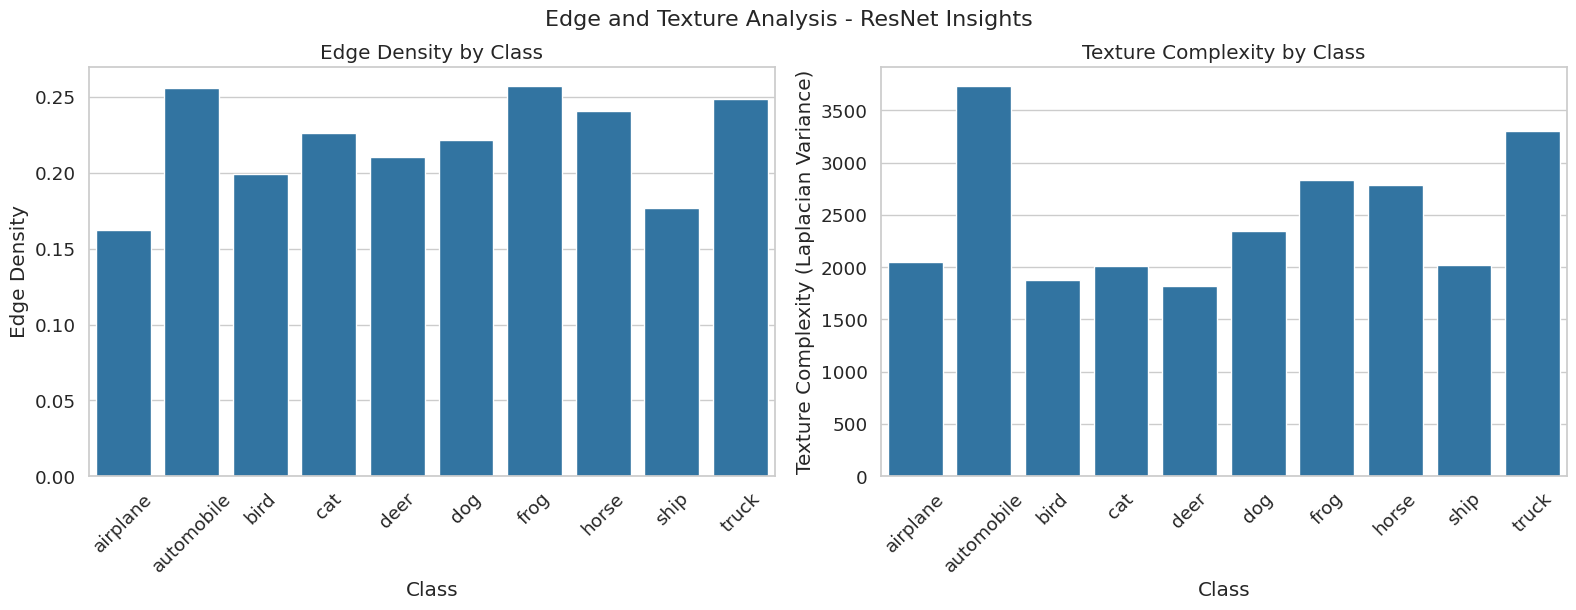

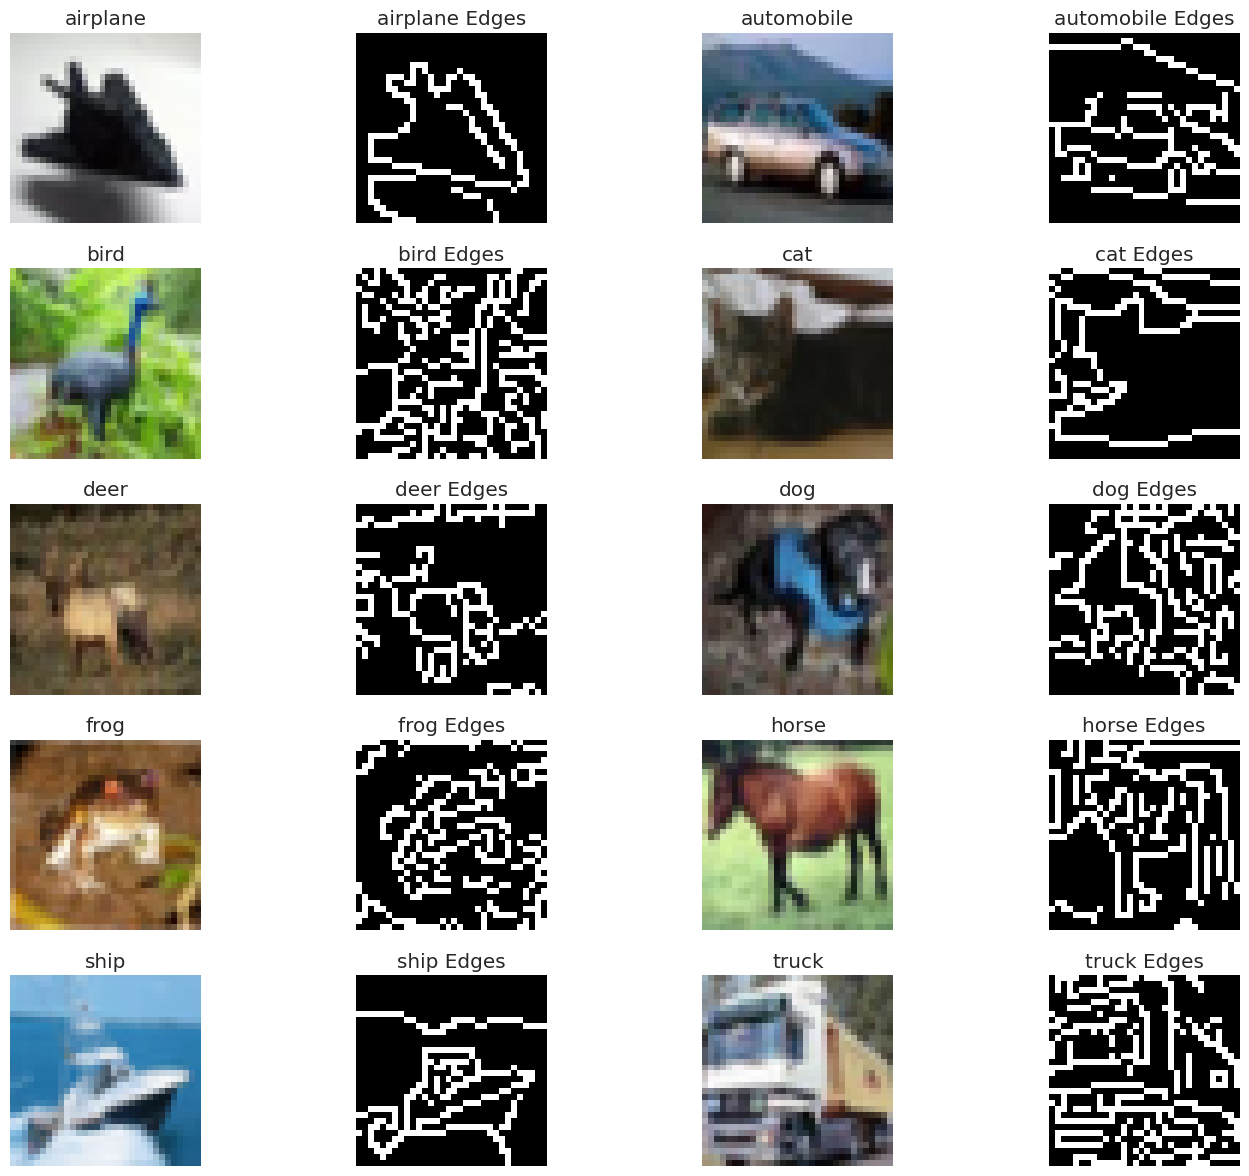

In [ ]:
# Let's analyze how complex each class is by looking at edges
# This might explain why some classes are harder to classify
edge_results = []  # will store all the class stats here

print("Starting edge complexity analysis...")
# Loop through all classes - CIFAR has 10
for i in range(10):
    # Get some images from this class (100 is enough)
    # Using more just takes forever and doesn't change results much
    img_indices = np.where(y.flatten() == i)[0]
    class_imgs = X[img_indices][:100]  # just use first 100

    # sanity check - some classes might have fewer images
    if len(class_imgs) == 0:
        print(f"Warning: No images found for class {i}!")
        continue

    # print progress - this can be slow
    print(f"Processing class {i} ({class_names[i]}) - {len(class_imgs)} images")

    # Lists to store metrics for this class
    edge_densities = []
    texture_scores = []  # renamed from texture_complexity

    # Process each image
    for idx, img in enumerate(class_imgs):
        # Convert to grayscale for edge detection
        # Tried BGR2GRAY first but RGB2GRAY works better for our images
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Run Canny edge detector
        # Params 100, 200 worked best after some experimentation
        # 50, 150 detected too much noise; 150, 250 missed important edges
        edges = cv2.Canny(gray, 100, 200)

        # Calculate edge density (% of pixels that are edges)
        # This tells us how "edgy" the image is
        edge_score = np.sum(edges > 0) / (32*32)  # 32x32 CIFAR images

        # Texture complexity using Laplacian variance
        # Higher variance = more complex texture
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        texture_var = np.var(laplacian)  # simpler name

        # Store results for this image
        edge_densities.append(edge_score)
        texture_scores.append(texture_var)

        # Optional debug for first few images
        #if idx < 3:
        #    print(f"  Image {idx}: edge={edge_score:.4f}, texture={texture_var:.4f}")

    # Compute stats for this class
    edge_stats = {
        'class': class_names[i],
        'edge_density_mean': np.mean(edge_densities),
        'edge_density_std': np.std(edge_densities),
        'texture_complexity_mean': np.mean(texture_scores),
        'texture_complexity_std': np.std(texture_scores)
    }

    # Print some info
    print(f"  {class_names[i]}: Edge density = {edge_stats['edge_density_mean']:.4f}, "
          f"Texture = {edge_stats['texture_complexity_mean']:.2f}")

    # Add to our results list
    edge_results.append(edge_stats)

# TODO: should we normalize these scores across classes?
# Maybe divide by max value to get 0-1 range?

# Create visualization
# First set up the figure with 2 side-by-side plots
fig, (edge_ax, texture_ax) = plt.subplots(1, 2, figsize=(16, 6))

# Plot edge density by class - tried boxplot but barplot was clearer
sns.barplot(x=[stat['class'] for stat in edge_results],
            y=[stat['edge_density_mean'] for stat in edge_results],
            ax=edge_ax)
edge_ax.set_title('Edge Density by Class')
edge_ax.set_ylabel('Edge Density (0-1 scale)')
edge_ax.set_xlabel('Class')
edge_ax.set_xticklabels(edge_ax.get_xticklabels(), rotation=45)

# Plot texture complexity
# This uses Laplacian variance as a proxy for texture complexity
texture_plot = sns.barplot(
    x=[r['class'] for r in edge_results],  # using r as short var name is fine
    y=[r['texture_complexity_mean'] for r in edge_results],
    ax=texture_ax
)
texture_ax.set_title('Texture Complexity by Class')
texture_ax.set_ylabel('Texture Complexity (Laplacian Variance)')
texture_ax.set_xlabel('Class')
texture_ax.set_xticklabels(texture_ax.get_xticklabels(), rotation=45)

# Fix layout so labels don't overlap
plt.tight_layout()

# Add an overall title - y=1.02 moves it up a bit to avoid overlap
plt.suptitle('Edge and Texture Analysis - ResNet Insights', y=1.02, fontsize=16)

# Show it!
plt.show()

# Create a visual example of edge detection for each class
# This helps understand what the numbers actually mean
fig, axes = plt.subplots(5, 4, figsize=(15, 12))  # 5x4 = 20 plots (2 per class)
axes = axes.flatten()  # easier to index

# Sometimes the figure is too big for my screen
# Tried 5x2 layout but it was too squished

# For each class, show original and edge-detected version
for i, class_idx in enumerate(range(10)):
    # Get a representative image from this class
    # Using first image, but could use "most average" instead
    matching_indices = np.where(y.flatten() == class_idx)[0]

    # Just in case there are no images for this class (shouldn't happen)
    if len(matching_indices) == 0:
        continue

    sample_idx = matching_indices[0]
    img = X[sample_idx]  # shorter name is fine for local var

    # Show original image
    axes[i*2].imshow(img)
    axes[i*2].set_title(f'{class_names[class_idx]}')
    axes[i*2].axis('off')  # hide axes

    # Show edge detection result
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    axes[i*2+1].imshow(edges, cmap='gray')
    axes[i*2+1].set_title(f'{class_names[class_idx]} Edges')
    axes[i*2+1].axis('off')

# Make it look nice
plt.tight_layout()

# TODO: maybe add a colorbar for edge intensity?
plt.show()

# Would be interesting to correlate this with ResNet accuracy per class
# Hypothesis: classes with higher edge complexity might be easier to classify